In [96]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [97]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
  if os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()
X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [98]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, num_classes)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.15)
            if module.bias is not None:
                module.bias.data.zero_()
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [99]:
model = LeNet(10)
model

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

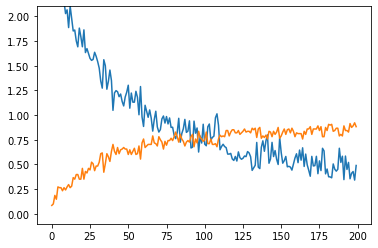

In [100]:
loss_function = nn.CrossEntropyLoss()
optim = torch.optim.SGD(model.parameters(), lr = 0.001)

BS = 128
losses, accuracies = [], []
for i in (range(200)):
  samp = np.random.randint(0, X_train.shape[0], size=(BS))
  X = torch.tensor(X_train[samp].reshape((BS,1,28,28))).float()
  Y = torch.tensor(Y_train[samp]).long()
  model.zero_grad()
  out = model(X)
  cat = torch.argmax(out, dim=1)
  accuracy = (cat == Y).float().mean()
  loss = loss_function(out, Y)
  loss = loss.mean()
  loss.backward()
  optim.step()
  optim.zero_grad()
  loss, accuracy = loss.item(), accuracy.item()
  losses.append(loss)
  accuracies.append(accuracy)
plt.ylim(-0.1, 2.1)
plt.plot(losses)
plt.plot(accuracies)

In [101]:
Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((10000,1, 28,28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.8782